## Library

In [ ]:
# Clear output for cleaner display
from IPython.display import clear_output
clear_output()

# Import libraries
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO
import supervision as sv
import json
from tracking_utils import *

print("✅ All dependencies installed successfully!")

✅ All dependencies installed successfully!


## Config Tracking

In [ ]:
class CFG:
    """Configuration class untuk tracking parameters"""

    # Model settings
    MODEL_WEIGHTS = "yolo11s.pt"  # YOLO11 small model

    # Heatmap parameters
    HEATMAP_ALPHA = 0.30
    RADIUS = 20
    KERNEL_SIZE = 25

    # Video paths
    VIDEO_FILE = "../sample_video/sample.mp4"  # Input video path
    OUTPUT_PATH = "./outputs/"  # Output directory

    # Grid size for heatmap analysis
    GRID_SIZE = 20


print("⚙️ Configuration loaded successfully!")

⚙️ Configuration loaded successfully!


In [33]:
# Generate sequence ID for file naming
sequence_id = get_next_sequence_id(CFG.OUTPUT_PATH)
identifer = str(sequence_id).zfill(3)  # Zero-pad to 3 digits

# make output directory if not exists
Path(f"{CFG.OUTPUT_PATH}{identifer}/").mkdir(parents=True, exist_ok=True)

In [34]:
# Your custom tracker.yaml configuration
tracker_config = """# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Default Ultralytics settings for BoT-SORT tracker when using mode="track"
# For documentation and examples see https://docs.ultralytics.com/modes/track/
# For BoT-SORT source code see https://github.com/NirAharon/BoT-SORT

tracker_type: botsort # tracker type, ['botsort', 'bytetrack']
track_high_thresh: 0.4 # threshold for the first association
track_low_thresh: 0.05 # threshold for the second association
new_track_thresh: 0.7 # threshold for init new track if the detection does not match any tracks
track_buffer: 300 # buffer to calculate the time when to remove tracks
match_thresh: 0.4 # threshold for matching tracks
fuse_score: True # Whether to fuse confidence scores with the iou distances before matching
# min_box_area: 10  # threshold for min box areas(for tracker evaluation, not used for now)

# BoT-SORT settings
gmc_method: none # method of global motion compensation
# ReID model related thresh
proximity_thresh: 0.2 # minimum IoU for valid match with ReID
appearance_thresh: 0.25 # minimum appearance similarity for ReID
with_reid: True
model: yolo11s-cls.pt # uses native features if detector is YOLO else yolo11n-cls.pt
"""

# Save your custom tracker configuration
with open("tracker.yaml", "w") as f:
    f.write(tracker_config)

print("🎯 Your custom BOTSORT tracker configuration loaded!")
print("✅ Features enabled: ReID, Global Motion Compensation, Score Fusion")

🎯 Your custom BOTSORT tracker configuration loaded!
✅ Features enabled: ReID, Global Motion Compensation, Score Fusion


In [35]:
# Get video properties
try:
    video_properties = get_video_properties(CFG.VIDEO_FILE)
    print("📹 Video Properties:")
    for key, value in video_properties.items():
        print(f"  {key}: {value}")
except Exception as e:
    print(f"⚠️ Error reading video properties: {e}")
    # Default properties for testing
    video_properties = {
        "fps": 30,
        "frame_count": 900,
        "duration_seconds": 30,
        "width": 1280,
        "height": 720,
        "codec": 875967080,
    }
    print("Using default video properties for testing")

📹 Video Properties:
  fps: 13
  frame_count: 261
  duration_seconds: 20
  width: 1270
  height: 720
  codec: 875967080


## Setting dan Run Model

In [36]:
# Initialize YOLO11 model
print("🔄 Loading YOLO11 model...")
model = YOLO(CFG.MODEL_WEIGHTS)
print(f"✅ {CFG.MODEL_WEIGHTS} loaded successfully!")

# Initialize supervision components
heat_map_annotator = sv.HeatMapAnnotator(
    position=sv.Position.BOTTOM_CENTER,
    opacity=CFG.HEATMAP_ALPHA,
    radius=CFG.RADIUS,
    kernel_size=CFG.KERNEL_SIZE,
    top_hue=0,
    low_hue=125,
)

label_annotator = sv.LabelAnnotator(
    text_position=sv.Position.CENTER, text_scale=0.5, text_thickness=1
)

print("🎨 Annotators initialized successfully!")

🔄 Loading YOLO11 model...
✅ yolo11s.pt loaded successfully!
🎨 Annotators initialized successfully!


In [37]:
# Execute optimized tracking
tracking_data, temp_video_file = perform_yolo11_tracking_optimized(
    CFG.VIDEO_FILE, CFG.OUTPUT_PATH, model, video_properties, identifer
)

🚀 Memulai tracking YOLO11 dengan konfigurasi BOTSORT kustom...
⚡ Fitur: ReID diaktifkan, Global Motion Compensation, Score Fusion

WARNING 'source' is missing. Using 'source=E:\CODING\BoT-SORT\env\Lib\site-packages\ultralytics\assets'.
video 1/1 (frame 1/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 6 persons, 149.5ms
video 1/1 (frame 2/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 6 persons, 118.5ms
video 1/1 (frame 3/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 6 persons, 217.7ms
video 1/1 (frame 4/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 6 persons, 146.7ms
video 1/1 (frame 5/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 6 persons, 184.2ms
video 1/1 (frame 6/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 7 persons, 160.6ms
video 1/1 (frame 7/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 7 persons, 195.8ms
video 1/1 (frame 8/261) e:\CODING\BoT-SORT\sample_video\sample.mp4: 384x640 7 persons, 110.2ms
vide

In [38]:
# Finalize video output
if "temp_video_file" in locals() and temp_video_file:
    final_video = finalize_video_output(temp_video_file, CFG.OUTPUT_PATH, identifer)
else:
    print("⚠️ No video file to process")
    final_video = None

# Save tracking data to CSV
if tracking_data:
    tracking_csv = f"{CFG.OUTPUT_PATH}{identifer}/yolo11_tracking_results_{identifer}.csv"

    tracking_df = pd.DataFrame(tracking_data)
    tracking_df.to_csv(tracking_csv, index=False)

    print(f"📄 Tracking data saved: {tracking_csv}")
    print(f"📊 Data shape: {tracking_df.shape}")

    # Quick data preview
    print("\n📋 Sample tracking data:")
    print(
        tracking_df[
            ["frame", "tracker_id", "confidence", "x_center", "y_center"]
        ].head()
    )

else:
    print("❌ No tracking data to save!")
    tracking_df = pd.DataFrame()

🎬 Mengkonversi ke format H.264: ./outputs/003/final_tracked_yolo11.mp4
✅ Video berhasil disimpan: ./outputs/003/final_tracked_yolo11.mp4
📄 Tracking data saved: ./outputs/003/yolo11_tracking_results_003.csv
📊 Data shape: (2628, 13)

📋 Sample tracking data:
   frame  tracker_id  confidence  x_center  y_center
0      0           1    0.876107  0.057967  0.486116
1      0           2    0.873844  0.716514  0.591393
2      0           3    0.833599  0.461799  0.123395
3      0           4    0.758365  0.892832  0.812949
4      0           5    0.755624  0.765656  0.819771


## Analisis Data

In [39]:
# Generate analysis data
df, fps, frame_width, frame_height = generate_analysis_data(
    tracking_data, video_properties
)

if df is not None:
    person_log_df = generate_person_log(df, fps, frame_width, frame_height)
    print(f"👥 Generated logs for {len(person_log_df)} persons")
else:
    print("❌ Unable to generate analysis data")

🔄 Memproses data tracking untuk analisis...
📊 Ditemukan 18 orang unik dalam 2628 deteksi
👥 Generated logs for 18 persons


In [40]:
# Generate heatmap and summary
if df is not None and not person_log_df.empty:
    heatmap_data_df = generate_heatmap_data(
        df, frame_width, frame_height, fps, CFG.GRID_SIZE
    )
    summary_stats = generate_summary_stats(df, person_log_df, heatmap_data_df)

    print("✅ Analysis data generated successfully!")
else:
    print("⚠️ Skipping heatmap generation due to missing data")

🔥 Menghasilkan data heatmap...
✅ Analysis data generated successfully!


📈 Generating all visualizations...


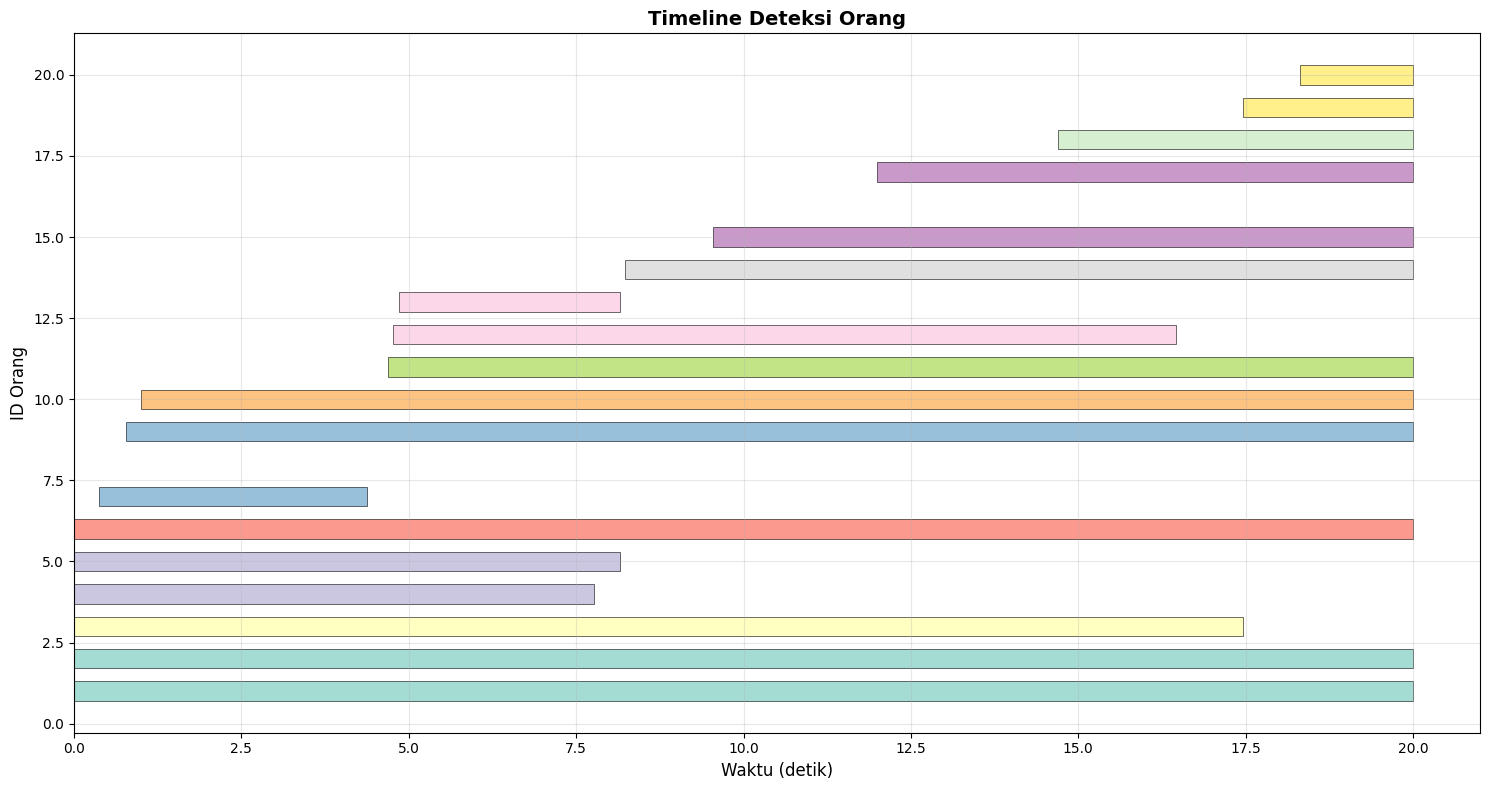

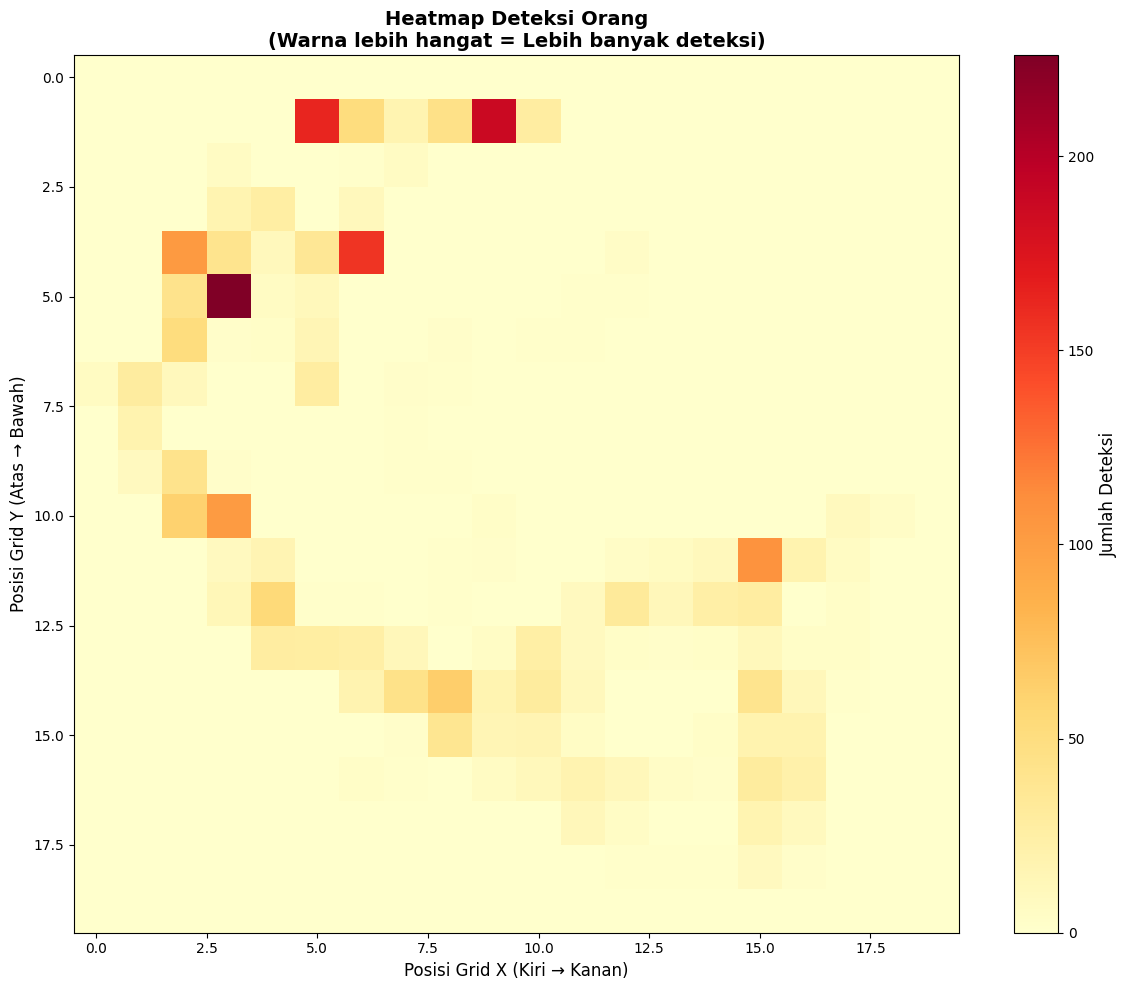

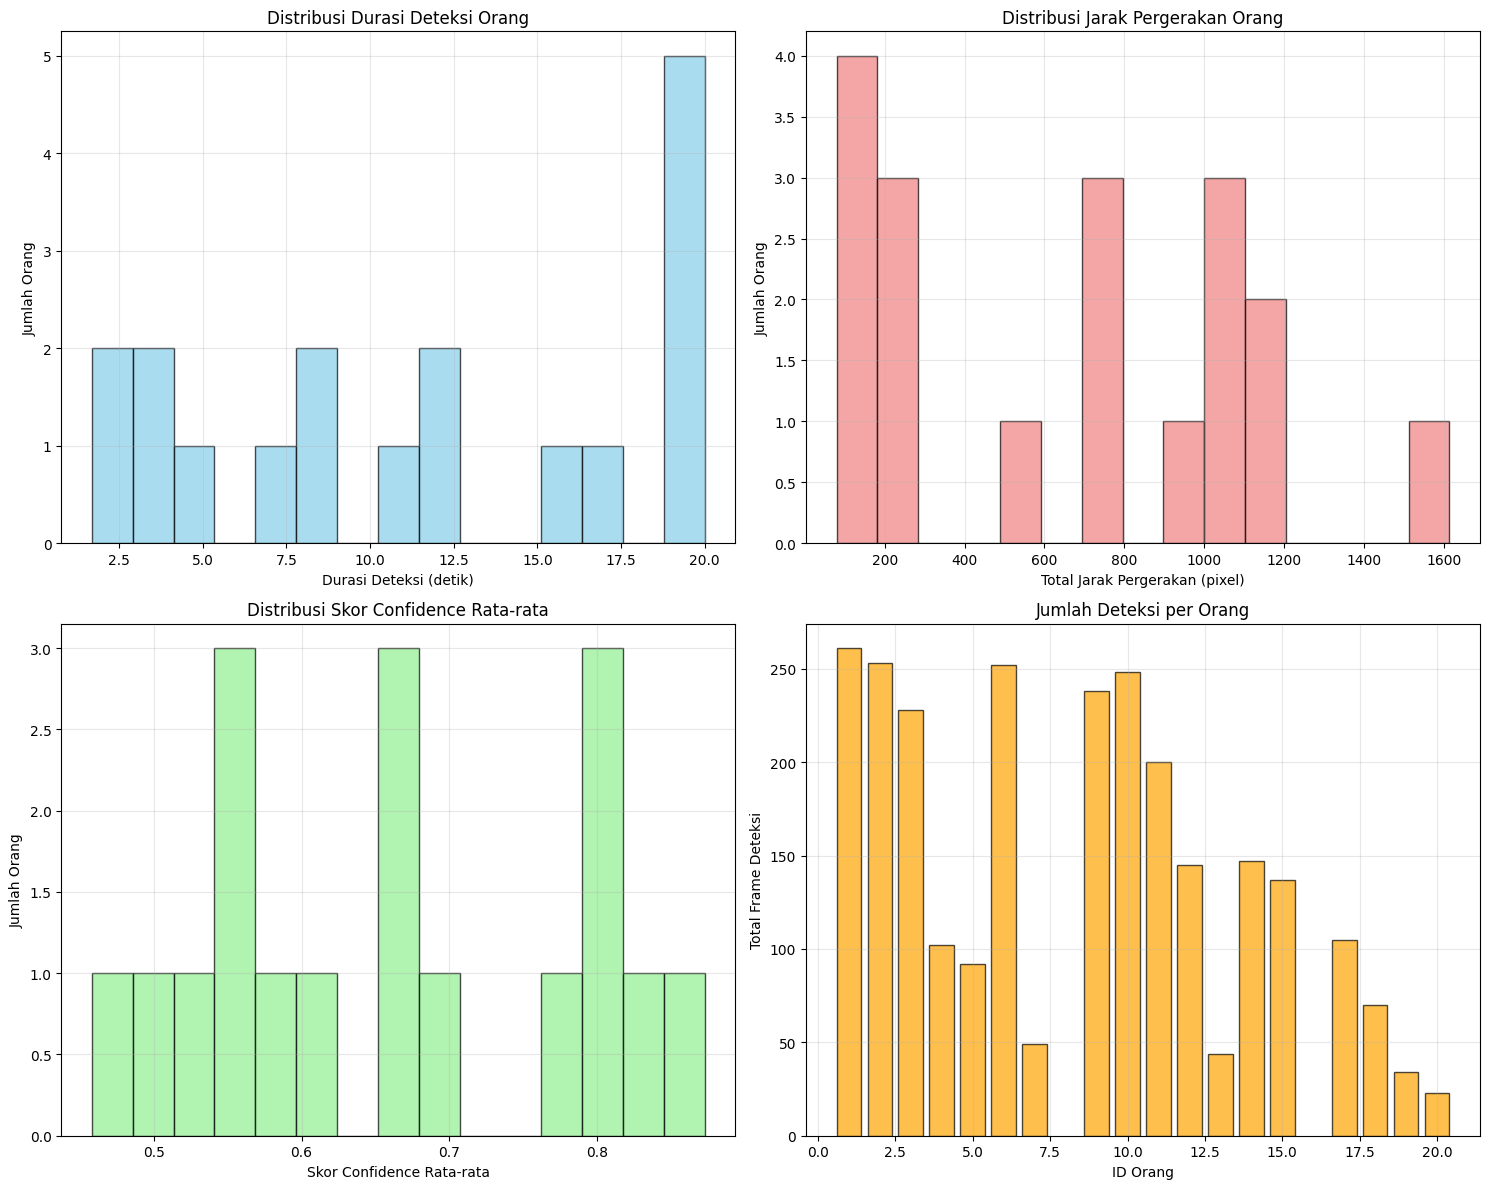


📊 STATISTIK RINGKASAN DETEKSI
👥 Total orang unik terdeteksi: 18
🎯 Total deteksi: 2,628
⏱  Durasi video: 20.0 detik
📈 Rata-rata orang per frame: 10.07
🏆 Maksimum orang dalam satu frame: 12
🔥 Orang paling aktif: ID #1
⏰ Orang terlama dilacak: ID #1
📍 Titik terpanas: Grid (5, 3) dengan 226 deteksi

✅ YOLO11 ANALYSIS COMPLETE!
📹 Output video: ./outputs/003/final_tracked_yolo11.mp4
📋 Person detection log: ./outputs/003/person_detection_log_003.csv
🔥 Heatmap data: ./outputs/003/heatmap_data_003.csv
📊 Summary statistics: ./outputs/003/detection_summary_003.json


In [41]:
# Execute complete visualization and analysis pipeline
if "person_log_df" in locals() and not person_log_df.empty:
    print("📈 Generating all visualizations...")

    # Generate visualizations
    plot_person_timeline(person_log_df, CFG.OUTPUT_PATH, identifer)

    if "heatmap_data_df" in locals() and not heatmap_data_df.empty:
        plot_detection_heatmap(
            heatmap_data_df, CFG.OUTPUT_PATH, identifer, CFG.GRID_SIZE
        )

    plot_activity_analysis(person_log_df, CFG.OUTPUT_PATH, identifer)

    # Display summary statistics
    if "summary_stats" in locals():
        display_summary_stats(summary_stats)

    # Save all results to files
    person_log_filename = f"{CFG.OUTPUT_PATH}{identifer}/person_detection_log_{identifer}.csv"
    person_log_df.to_csv(person_log_filename, index=False)

    if "heatmap_data_df" in locals():
        heatmap_filename = f"{CFG.OUTPUT_PATH}{identifer}/heatmap_data_{identifer}.csv"
        heatmap_data_df.to_csv(heatmap_filename, index=False)

    if "summary_stats" in locals():
        summary_filename = f"{CFG.OUTPUT_PATH}{identifer}/detection_summary_{identifer}.json"
        with open(summary_filename, "w") as f:
            json.dump(summary_stats, f, indent=2)

    print("\n" + "=" * 60)
    print("✅ YOLO11 ANALYSIS COMPLETE!")
    print("=" * 60)
    print(
        f"📹 Output video: {final_video if 'final_video' in locals() else 'Not generated'}"
    )
    print(f"📋 Person detection log: {person_log_filename}")
    if "heatmap_data_df" in locals():
        print(f"🔥 Heatmap data: {heatmap_filename}")
    if "summary_stats" in locals():
        print(f"📊 Summary statistics: {summary_filename}")
    print("=" * 60)

else:
    print(
        "❌ No data available for analysis. Please check your video file and tracking results."
    )